# Projet 5 : Analyse Exploratoire

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os as os
import seaborn as sns
from random import sample
from scipy import stats
import scipy.stats as st
from sklearn import linear_model, metrics, svm
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from gensim import models, corpora

from gensim.models import phrases, Phrases, coherencemodel
import stop_words 
from nltk.tokenize import word_tokenize

from itertools import groupby
import operator

%matplotlib inline

plt.style.use('seaborn-notebook')
sns.set_style('ticks')
sns.set(rc={'figure.figsize': (12, 8)})
sns.set(rc={'font.size': 15})

os.getcwd()
os.chdir("C:/Users/flemeill/Documents/01 - Projets OC/05 - Projet 5/Main Project")

In [2]:
def distri_plot(Var, X):
    """Fonction permettant d'afficher la distribution statistique d'une variable (courbe + histogramme)"""
    sns.distplot(Var)
    plt.xlabel(X, fontsize=18)
    plt.ylabel("Distribution", fontsize=18)
    plt.title("Distribution de " + X, fontsize=24)
    print("La médiane de ", X, "est de ", Var.median())
    print("La moyenne de ", X, "est de ", Var.mean())


def boxplot1d(X, title):
    """Fonction permettant d'afficher la distribution statistique d'une variable en boite à moustache"""
    sns.boxplot(X)
    plt.title(title, fontsize=24)
    print(X.describe())


def evaluate_completnes_df(data):
    "Création de la fonction pour évaluer la complétion d'un jeu de données"
    IsNull = pd.isnull(data)
    EmptynessRatio = IsNull.sum().sum()/data.size
    return (print("La matrice est complète à :",
                  np.around((1-EmptynessRatio), decimals=3)*100, "%"))

In [3]:
corpus = pd.read_csv('QueryResults.csv')
print(corpus.shape)
print(corpus.head(4))

(50000, 4)
                                                Body  \
0  <p>Does Visual Studio .NET have a way to toggl...   
1  <p><strong>When viewing a document</strong>: E...   
2  <p>I lost my MySQL username and password. How ...   
3  <blockquote>\n  <p>Stop the MySQL process.</p>...   

                                               Title  Score  \
0       How can I toggle word wrap in Visual Studio?    221   
1                                                NaN    460   
2  How do I retrieve my MySQL username and password?    132   
3                                                NaN    167   

                         Tags  
0  <visual-studio><word-wrap>  
1                         NaN  
2                     <mysql>  
3                         NaN  


In [4]:
corpus.isnull().sum(axis=0)

Body         0
Title    32754
Score        0
Tags     32753
dtype: int64

In [5]:
corpus_filtered = corpus.dropna()

In [6]:
corpus_filtered.shape

(17246, 4)

In [7]:
Title = pd.Series(corpus_filtered.Title)
Body = pd.Series(corpus_filtered.Body)
Tags = pd.Series(corpus_filtered.Tags)

# Pre-traitement du texte

In [8]:
import stop_words
sw = stop_words.get_stop_words(language='en')



In [9]:
Tokens_Body = corpus_filtered.Body.map(lambda text:
                                [w for w in text.replace('.', '').replace(',', '').replace('!', '').replace('<p>', '').replace('</p>', '').split() if w])


In [10]:
Tokens_Body = corpus_filtered.Body.map(lambda text: word_tokenize(text))
Title_Tokens = corpus_filtered.Title.map(lambda text: word_tokenize(text))

In [11]:
import re
Tokens_Body_clean =  Tokens_Body.map(
                                    lambda tok: [t.lower() for t in re.split(" ", re.sub(r"(\W+|_|\d+)", " ", " ".join(tok))) \
                                                 if t.lower() not in sw and len(t)>1]
                        )

Title_Tokens_clean =  Title_Tokens.map(
                                    lambda tok: [t.lower() for t in re.split(" ", re.sub(r"(\W+|_|\d+)", " ", " ".join(tok))) \
                                                 if t.lower() not in sw and len(t)>1]
                        )

In [12]:
Corpus = corpus_filtered
Corpus['Body_token'] = pd.Series(Tokens_Body_clean)
Corpus['Title_token'] = pd.Series(Title_Tokens_clean)

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
Corpus.head()

,Body,Title,Score,Tags,Body_token,Title_token
0,<p>Does Visual Studio .NET have a way to toggl...,How can I toggle word wrap in Visual Studio?,221,<visual-studio><word-wrap>,"[visual, studio, net, way, toggle, word, wrap,...","[can, toggle, word, wrap, visual, studio]"
2,<p>I lost my MySQL username and password. How ...,How do I retrieve my MySQL username and password?,132,<mysql>,"[lost, mysql, username, password, retrieve]","[retrieve, mysql, username, password]"
5,<p>I'd like a script to drop all tables whose ...,Drop all tables whose names begin with a certa...,121,<sql><sql-server><scripting><dynamic-sql>,"[like, script, drop, tables, whose, name, begi...","[drop, tables, whose, names, begin, certain, s..."
7,<p>The firewall I'm behind is running Microsof...,How do I update Ruby Gems from behind a Proxy ...,209,<ruby><proxy><rubygems><ironruby>,"[firewall, behind, running, microsoft, isa, se...","[update, ruby, gems, behind, proxy, isa, ntlm]"
10,"<p>What fonts do you use for programming, and ...",Recommended Fonts for Programming?,183,<fonts><development-environment>,"[fonts, use, programming, language, ide, use, ...","[recommended, fonts, programming]"


In [14]:
Corpus.Tags.nunique()

13574

In [15]:
Tags = corpus_filtered.Tags.map(lambda text:
                                [w for w in text.replace('<','').replace('>',' ').replace('|','').split() if w])
Corpus.Tags = Tags
Tags

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


0                               [visual-studio, word-wrap]
2                                                  [mysql]
5                [sql, sql-server, scripting, dynamic-sql]
7                        [ruby, proxy, rubygems, ironruby]
10                        [fonts, development-environment]
12                          [functional-programming, lisp]
13                                                 [regex]
14                   [asp.net, configuration, asp-classic]
18                          [windows, git, cygwin, editor]
19                               [mysql, sql-server, tsql]
21                                                    [go]
23                     [unit-testing, integration-testing]
24                    [ios, objective-c, cocoa-touch, sms]
25                   [c#, .net, linq, datatable, .net-3.5]
28          [c++, algorithm, optimization, floating-point]
29                                                [assert]
31                            [linux, email, command-lin

In [16]:
Corpus.head()

,Body,Title,Score,Tags,Body_token,Title_token
0,<p>Does Visual Studio .NET have a way to toggl...,How can I toggle word wrap in Visual Studio?,221,"[visual-studio, word-wrap]","[visual, studio, net, way, toggle, word, wrap,...","[can, toggle, word, wrap, visual, studio]"
2,<p>I lost my MySQL username and password. How ...,How do I retrieve my MySQL username and password?,132,[mysql],"[lost, mysql, username, password, retrieve]","[retrieve, mysql, username, password]"
5,<p>I'd like a script to drop all tables whose ...,Drop all tables whose names begin with a certa...,121,"[sql, sql-server, scripting, dynamic-sql]","[like, script, drop, tables, whose, name, begi...","[drop, tables, whose, names, begin, certain, s..."
7,<p>The firewall I'm behind is running Microsof...,How do I update Ruby Gems from behind a Proxy ...,209,"[ruby, proxy, rubygems, ironruby]","[firewall, behind, running, microsoft, isa, se...","[update, ruby, gems, behind, proxy, isa, ntlm]"
10,"<p>What fonts do you use for programming, and ...",Recommended Fonts for Programming?,183,"[fonts, development-environment]","[fonts, use, programming, language, ide, use, ...","[recommended, fonts, programming]"


In [17]:
Corpus['body_length'] = Corpus['Body'].apply(len)

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [18]:
Corpus['Title_Body'] = Corpus['Body_token'] + Corpus['Title_token']

C:\Users\flemeill\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [30]:
Corpus.head()

,Body,Title,Score,Tags,Body_token,Title_token,body_length,Title_Body
0,<p>Does Visual Studio .NET have a way to toggl...,How can I toggle word wrap in Visual Studio?,221,"[visual-studio, word-wrap]","[visual, studio, net, way, toggle, word, wrap,...","[can, toggle, word, wrap, visual, studio]",513,"[visual, studio, net, way, toggle, word, wrap,..."
2,<p>I lost my MySQL username and password. How ...,How do I retrieve my MySQL username and password?,132,[mysql],"[lost, mysql, username, password, retrieve]","[retrieve, mysql, username, password]",68,"[lost, mysql, username, password, retrieve, re..."
5,<p>I'd like a script to drop all tables whose ...,Drop all tables whose names begin with a certa...,121,"[sql, sql-server, scripting, dynamic-sql]","[like, script, drop, tables, whose, name, begi...","[drop, tables, whose, names, begin, certain, s...",344,"[like, script, drop, tables, whose, name, begi..."
7,<p>The firewall I'm behind is running Microsof...,How do I update Ruby Gems from behind a Proxy ...,209,"[ruby, proxy, rubygems, ironruby]","[firewall, behind, running, microsoft, isa, se...","[update, ruby, gems, behind, proxy, isa, ntlm]",330,"[firewall, behind, running, microsoft, isa, se..."
10,"<p>What fonts do you use for programming, and ...",Recommended Fonts for Programming?,183,"[fonts, development-environment]","[fonts, use, programming, language, ide, use, ...","[recommended, fonts, programming]",317,"[fonts, use, programming, language, ide, use, ..."


In [74]:
import csv
Corpus.to_csv(path_or_buf='C:/Users/flemeill/Documents/01 - Projets OC/05 - Projet 5/Main project/Corpus_clean.csv',
             encoding='utf_8')

In [22]:
Tags = Corpus.Tags.tolist()
Tags 

[['visual-studio', 'word-wrap'],
 ['mysql'],
 ['sql', 'sql-server', 'scripting', 'dynamic-sql'],
 ['ruby', 'proxy', 'rubygems', 'ironruby'],
 ['fonts', 'development-environment'],
 ['functional-programming', 'lisp'],
 ['regex'],
 ['asp.net', 'configuration', 'asp-classic'],
 ['windows', 'git', 'cygwin', 'editor'],
 ['mysql', 'sql-server', 'tsql'],
 ['go'],
 ['unit-testing', 'integration-testing'],
 ['ios', 'objective-c', 'cocoa-touch', 'sms'],
 ['c#', '.net', 'linq', 'datatable', '.net-3.5'],
 ['c++', 'algorithm', 'optimization', 'floating-point'],
 ['assert'],
 ['linux', 'email', 'command-line'],
 ['c++', 'oop', 'encapsulation', 'friend'],
 ['.net', 'warnings'],
 ['c#', 'java', 'math'],
 ['linux', 'bash', 'unix', 'coredump', 'tcsh'],
 ['javascript', 'validation', 'numbers'],
 ['firefox', 'firefox-addon', 'add-on'],
 ['javascript', 'jquery', 'string', 'escaping'],
 ['javascript', 'settimeout'],
 ['c', 'for-loop', 'post-increment', 'pre-increment'],
 ['c', 'gcc', 'for-loop'],
 ['c', 'pe

In [36]:
def plot_top_occur(Serie, N): 
    new_list = [item for sublist in Serie for item in sublist] 
    freq = {key:len(list(group)) for key, group in groupby(np.sort(new_list))}
    sorted_freq = sorted(freq.items(), key=operator.itemgetter(1), reverse=True)
    
    tags_N = []
    freq_N = []
    for i in range(N):
        tags_N.append(sorted_freq[i][0])
        freq_N.append(sorted_freq[i][1])
        
    fig = plt.figure(figsize=(14, 7))
    sns.barplot(y=tags_N, x=freq_N)
    plt.title("Nombre d'occurrence des mots", fontsize = 18)
    plt.show()

Occurrences des mots dans Title + Body 

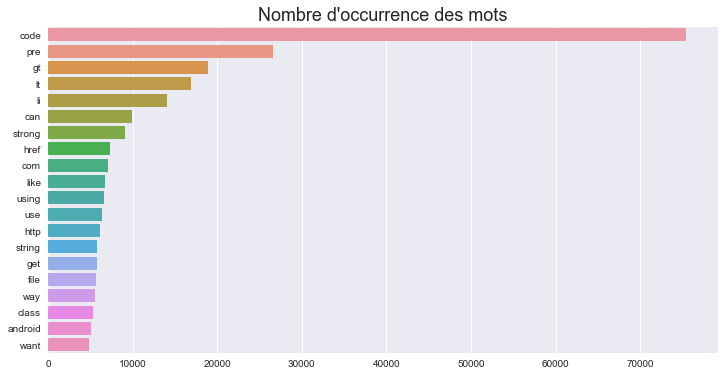

In [37]:
plot_top_occur(Corpus['Title_Body'], 20)

Occurrences des mots dans Title 

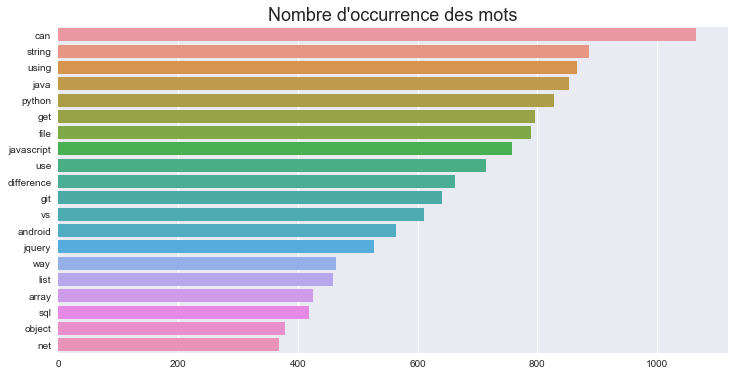

In [38]:
plot_top_occur(Corpus['Title_token'], 20)

Occurrences des mots dans Body 

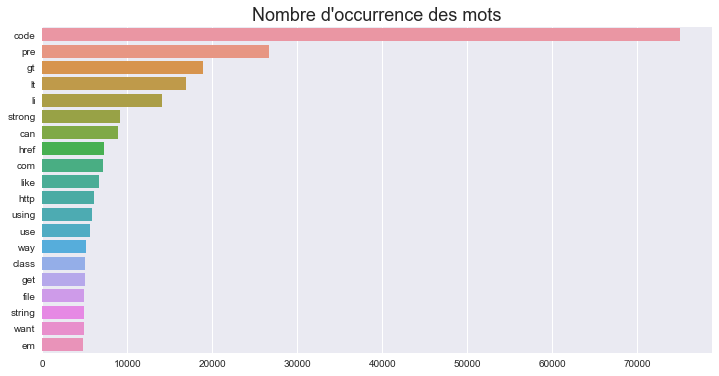

In [39]:
plot_top_occur(Corpus['Body_token'], 20)

In [40]:
Corpus.head()

,Body,Title,Score,Tags,Body_token,Title_token,body_length,Title_Body
0,<p>Does Visual Studio .NET have a way to toggl...,How can I toggle word wrap in Visual Studio?,221,"[visual-studio, word-wrap]","[visual, studio, net, way, toggle, word, wrap,...","[can, toggle, word, wrap, visual, studio]",513,"[visual, studio, net, way, toggle, word, wrap,..."
2,<p>I lost my MySQL username and password. How ...,How do I retrieve my MySQL username and password?,132,[mysql],"[lost, mysql, username, password, retrieve]","[retrieve, mysql, username, password]",68,"[lost, mysql, username, password, retrieve, re..."
5,<p>I'd like a script to drop all tables whose ...,Drop all tables whose names begin with a certa...,121,"[sql, sql-server, scripting, dynamic-sql]","[like, script, drop, tables, whose, name, begi...","[drop, tables, whose, names, begin, certain, s...",344,"[like, script, drop, tables, whose, name, begi..."
7,<p>The firewall I'm behind is running Microsof...,How do I update Ruby Gems from behind a Proxy ...,209,"[ruby, proxy, rubygems, ironruby]","[firewall, behind, running, microsoft, isa, se...","[update, ruby, gems, behind, proxy, isa, ntlm]",330,"[firewall, behind, running, microsoft, isa, se..."
10,"<p>What fonts do you use for programming, and ...",Recommended Fonts for Programming?,183,"[fonts, development-environment]","[fonts, use, programming, language, ide, use, ...","[recommended, fonts, programming]",317,"[fonts, use, programming, language, ide, use, ..."


In [62]:
Corpus.isnull().sum()

Body           0
Title          0
Score          0
Tags           0
Body_token     0
Title_token    0
body_length    0
Title_Body     0
dtype: int64

## Analyse de la correspondance Tags - Titres - Body 

#### Tag - Titre + Body

In [60]:
# Regardons si le tag se retrouve toujours dans Title+Body
no_tag_in_txt = 0
for i, row in Corpus.iterrows():
    for l in range(len(row['Tags'])):
        tt = row['Tags'][l]
        tag_in_body = False
        for t in tt:
            if t in str.lower(row['Title_Body'][l]):
                tag_in_body = True
                break
            t = t.replace('-', ' ')
            if t in str.lower(row['Title_Body'][l]):
                tag_in_body = True
                break
    if not tag_in_body:
            no_tag_in_txt += 1
            #print(tt)
            #if 'java' in tt:
            #    print(row['TagsCleaned'] + '\n' + row['Title'] + '\n' + row['Body'])
            #break
print(no_tag_in_txt)
print(round(no_tag_in_txt/Corpus.Tags.count()*100,1),
"% du temps, aucun des tags ne provient du texte + titre de l'utilisateur")

2475
14.4 % du temps, aucun des tags ne provient du texte + titre de l'utilisateur


In [72]:
# Regardons si tous les tags se retrouvent dans Title+Body
all_tags_in_txt = 0
for i, row in Corpus.iterrows():
    for l in range(len(row['Tags'])):
        tt = row['Tags'][l]
        tags_in_body = True
        for t in tt:
            if t in str(row['Title_Body'][l]):
                continue
            t = t.replace('-', ' ')
            if t in str(row['Title_Body'][l]):
                continue
            tags_in_body = False
            break
        if tags_in_body:
            all_tags_in_txt += 1
#    if tags_in_body:
#        print(row['TagsCleaned'])
#        print(row['Title'])
#        print(row['Body'])
#        break
print(all_tags_in_txt)
print(round(all_tags_in_txt/Corpus.Tags.count()*100,1),
      "% du temps, tous les tags sont dans le texte")

2229
12.9 % du temps, tous les tags sont dans le texte
